# Model Comparison using Kombine
We perform a more advanced task in this notebook and use an established bayesian modeling tool: [Kombine](https://github.com/bfarr/kombine).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from corner import corner
import pandas as pd
import numpy as np
import kombine

## Step 1: Gather data
We are going to use data from [Dutta and Sherrill (2003)](https://aip.scitation.org/doi/10.1063/1.1531658) who computed the bond energy of the HF molecule as a function of distance

In [2]:
data = pd.read_csv('datasets/hf-bond-energy.csv')
data = data.sample(12).sort_values('R')  # Reduce the amount of data as an experiment later

Text(0, 0.5, 'E (Ha)')

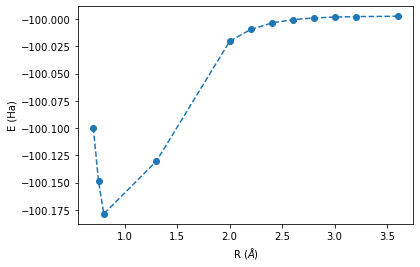

In [3]:
fig, ax = plt.subplots()

ax.plot(data['R'], data['E'], '--o')

ax.set_xlabel('R ($\\AA$)')
ax.set_ylabel('E (Ha)')

We see a bond that has a minimum around $0.9 \unicode{xC5}$ that plateaus out to be around -100, which is the energy of the broken state.

For simplicity, we are going to compute an energy where broken is 0

In [4]:
data['dE'] = data['E'] - data['E'].max()

## Step 2: Introducing the Models
There are many models that can explain bond energy that look like this, we are going to use 2 of them:

- [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential): $E = 4\epsilon [(\sigma/r)^{12} - (\sigma/r)^6]$
- [Morse](https://en.wikipedia.org/wiki/Morse_potential): E = $D_e(1 - e^{-\alpha(r-r_e)})^2 - D_e$
- [Buckingham](https://en.wikipedia.org/wiki/Buckingham_potential): $E = A\exp(-Br) - \frac{C}{r^6}$

Before getting started using Bayesian methods, we must establish reasponable priors for these model.
We will do that by finding the optimal parameters by fitting the parameters to the data

In [5]:
def lj(r, e, s):
    """Compute the energy using Lennard-Jones potential
    
    Args:
        r: Bond distances
        e: Bond energy term (epsilon)
        s: Bond length term (sigma)
    Return:
        Energies at each distance
    """
    rn = np.divide(s, r)
    return 4 * e * (np.power(rn, 12) - np.power(rn, 6))

In [6]:
def morse(r, d, a, r_e):
    """Compute the energy using Lennard-Jones potential
    
    Args:
        r: Bond distances
        d: Bond energy term (D_e)
        a: Bond stretching term (alpha)
        r_e: Bond length term (r_e)
    Return:
        Energies at each distance
    """
    return d * np.power(1 - np.exp(-a * np.subtract(r, r_e)), 2) - d

In [7]:
def buckingham(r, A, B, C):
    """Compute the energy using a Buckingham potential
    
    Args:
        r: Bond distances
        A: Repulsion strength
        B: Repulsion distance
        C: Attraction strength
    Return:
        Energies at each distance
    """
    return A * np.exp(np.multiply(-B, r)) - np.divide(C, np.power(r, 12))

Fit them using scipy's [`curve_fit` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [8]:
lj_opt, _ = curve_fit(lj, data['R'], data['dE'])

In [9]:
morse_opt, _ = curve_fit(morse, data['R'], data['dE'])

In [10]:
buck_opt, _ = curve_fit(buckingham, data['R'], data['dE'])

Plot them

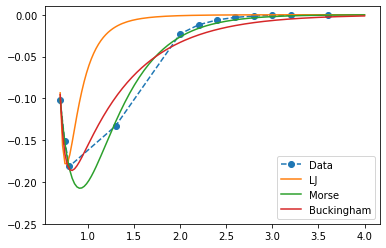

In [11]:
fig, ax = plt.subplots()
ax.plot(data['R'], data['dE'], '--o', label='Data')

r = np.linspace(0.7, 4, 128)
ax.plot(r, lj(r, *lj_opt), label='LJ')
ax.plot(r, morse(r, *morse_opt), label='Morse')
ax.plot(r, buckingham(r, *buck_opt), label='Buckingham')

ax.set_ylim(-0.25, 0.01)

ax.legend()

Morse is clearly the best fit to the data, but let's be precise about it using Bayesian methods

## Defining the Model Fitting as a Bayesian Problem
As shown in the previous notebook, we define our problem by establishing a prior distribution and a "likelihood" function.

But first, we add an error term to the model that describes our expectation of the model's reliability. Let's choose a Guassian form for that error model, which makes the Morse potential a 4-parameter model:

$E(r|D_e,\alpha,r_e,\epsilon) = D_e(1 - e^{-\alpha(r-r_e)})^2 - D_e + N(0, \epsilon)$

where $N(0, \epsilon)$ is a normal distribution with a mean of 0 and a standard deviation of $\epsilon$. This will be important when defining our logarithmic function.

### Defining a Prior Distribution
The prior distribution defines our initial expectation for the values of the parameters. We'll need to establish one for each of the parameters and the error term in the above model, and we'll use the data from the initial fit to build those. 

Specifically, we'll assume a normal distribution for the model parameters with a mean of those we fit previously and standard deviation of 10% of the mean.

We will let the error term be equal to the root mean square error of the model from our previous fitting and assume an expotential distribution.

To implement these, we define each distribution using [SciPy](https://docs.scipy.org/doc/scipy/reference/stats.html).

In [12]:
priors = [
    stats.norm(p, 0.1 * p) for p in morse_opt
]

# For the error distribution
rmse = np.sqrt(np.power(morse(data['R'], *morse_opt) - data['dE'], 2).sum())
priors.append(stats.expon(scale=rmse))

These objects give us useful utilities such as being about to plot the distributions

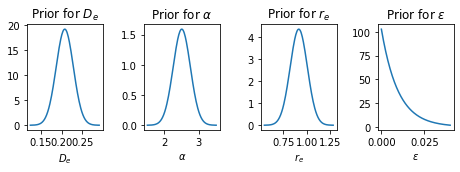

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(6.5, 2.5))

# Make the distributiosn for each parameter
for ax, prior, m, l in zip(axs, priors, morse_opt, ['$D_e$', '$\\alpha$', '$r_e$']):
    r = np.linspace(m - 0.4 * m, m + 0.4 * m, 128)
    ax.plot(r, prior.pdf(r))
    
    ax.set_title(f'Prior for {l}')
    ax.set_xlabel(l)
    
# Make the distribution for the model error
r = np.linspace(1e-6, 0.04, 128)
ax = axs[-1]
ax.plot(r, priors[-1].pdf(r))
ax.set_title(f'Prior for $\\epsilon$')
ax.set_xlabel('$\\epsilon$')


    
fig.tight_layout()

We can also generate many example model parameters by sampling from these priors

In [14]:
p0 = np.array(list(zip(p.rvs(size=(32,)) for p in priors)))  # Get 32 shapes from each prior

In [15]:
p0 = np.squeeze(p0).T  # Shape them into a (32 x 4) array

Text(0, 0.5, 'E (Ha)')

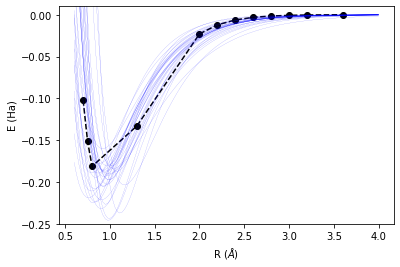

In [16]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(data['R'], data['dE'], 'k--o')

# Plot the data
r = np.linspace(0.6, 4, 128)
for p in p0:
    e = morse(r, *p[:-1])
    ax.plot(r, e, 'b-', lw=0.1, alpha=0.9)
    
    
ax.set_ylim(-0.25, 0.01)

ax.set_xlabel('R ($\\AA$)')
ax.set_ylabel('E (Ha)')

The above shows a big population of models that *could* explain our data. Our next step is to create a function to mark which ones are more likely. 

### Defining a Likelihood Function

As noted in our previous notebook, the likelihood function requires both assessing the likelihood of observing the data given our model and the parameters:

$P(\theta|D,M)=P(D|\theta,M)P(\theta|M)$

The function has two parts:
1. $P(\theta|M)$: The probability function of the parameters given our prior expectation
1. $P(D|\theta,M)$: The likelihood of observing the data given our parameters

Our goal is to create a probability distribution as a function of $\theta$ for each. Creating these functions often involves multiplying large and small numbers together, which is problematic due to [how computers perform multiplication](https://en.wikipedia.org/wiki/Floating-point_arithmetic#Accuracy_problems). So, we are going to write functions that compute the logarithm of this probability distribution function - "log-likelihood"

Computing using the prior is relatively easy. We have the prior distribution defined using Scipy, and we can call the "PDF" function to get them. As we have multiple parameters, the likelihood of observing a certain collection of parameters is the [product of the probability functions for each](https://en.wikipedia.org/wiki/Chain_rule_(probability)).

In [17]:
def prior_logpdf(params, priors):
    """Evalulate the logarithm PDF probability distribution function for the prior distributions
    
    We compute the logarithm of the PDF to avoid issues around multiplying large numbers
    
    Args:
        params: A certain set of parameters
        priors: The prior distributiuon for each parameter
    """
    
    # Sum the log-liklihood for the parameters in each prior distribution
    logpdf = 0
    for prior, th in zip(priors, params):
        logpdf += prior.logpdf(th)
    return logpdf

Evaluating the $P(D|\theta,M)$ term uses the error model we define along with the Morse function (that normal distribution term we defined above).

Assume we have an observed energy, $E_{obs}$, at distance $r$ and a model for the energy as $E(r) = \textrm{Morse}(r, D_e, \alpha, r_e)+ N(0, \epsilon)$.

We can compute the error between the observed energy and that predicted using the model: $\Delta E = E_obs - E(r) = N(0, \epsilon)$

This relates the error to a distribution, so we can compute the log-likelihood of the value of the error given the error value. We have more than one point, so the probability of seeing all of them is the product of the likelihoods of errors in the model for each points points.

In [18]:
def data_loglikelihood(params, model, data):
    """Compute the log-likelihood of observing our data given the model parameters
    
    Args:
        params: Parameters of the model
    Return:
        Log-likelihood
    """
    
    # Compute the values for the Morse function
    e_pred = model(data['R'], *params[:-1])  # The first N-1 parameters are of the morse model
    
    # Compute the error for each point
    e_error = data['dE'] - e_pred
    
    # Sum the log-likelihoods for observing each error
    #  based on the width of the error distribution (the last parameter)
    return stats.norm(0, scale=params[-1]).logpdf(e_error).sum()

### Creating a tool to compute the posterior likelihdood.
Together, the functions above define the ability to generate the posterior distribution for the parameters.
With these in hand, we make a single tool that will compute the log-likelihdoof for any set of parameters using different data sources, models, or prior distributions.

In [19]:
class PosteriorPDF(object):
    def __init__(self, model, priors, data):
        """Args:
            model: Model used to compute energy
            priors: Prior distribution of the parameters
            data: Data to use for fitting
        """
        self.model = model
        self.priors = priors
        self.data = data
        
    def __call__(self, x):
        return prior_logpdf(x, self.priors) + data_loglikelihood(x, self.model, self.data)
lnpdf = PosteriorPDF(morse, priors, data)

We can use this to compute the ratio in posterior probabilities between different sets of parameters

In [20]:
lnpdf_diff = lnpdf(p0[0, :]) - lnpdf(p0[1, :])
print(f'Ratio between likelihoods of the first two sampled points: {np.exp(lnpdf_diff):.2e}')

Ratio between likelihoods of the first two sampled points: inf


/home/wardlt/miniconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


We now are ready to MCMC sampling!

## Sampling from the Posterior
As discussed in our previous notebook, Metropolis-Hastings (MH) sampling is effective but inefficient. The small jumps in parameters lead to correlation between guesses, which slows down the rate at which parameter space is explored (you get stuck around your current guess). The [`kombine` program](https://pages.uoregon.edu/bfarr/kombine/index.html) uses an [ensemble algorithm](https://projecteuclid.org/euclid.camcos/1513731992) that avoids these issues for reasons out-of-scope for this class.

Here, we describe how to use it.

### Step 1: Seed the sampling algorithm
We will generate samples from our prior distribution to produce an initial set of points to begin our sampling.
We choose 500 as an experiment.

In [21]:
n_walkers = 128  # Number of samples to start with
p0 = np.vstack([  # Combines samples from each prior to form one array
    p.rvs(size=(n_walkers,)) for p in priors  # Generate random samples from each prior
]).T  # Flips it from <parameters>x<walkers> to <walkers>x<parameters>, as expected by kombine
print(f'Created a starting array of shape: {p0.shape}')

Created a starting array of shape: (128, 4)


### Step 2: Make the Sampler
The [`Sampler` class](https://pages.uoregon.edu/bfarr/kombine/kombine.html#kombine.sampler.Sampler) is the tool in combine that generates samples from the posterior
distribution. We create it by telling how many "walkers" to use (we perform sampling from many different random starting points), the number of parameters in the model, and a function that gives their likelihood over time

In [22]:
sampler = kombine.Sampler(n_walkers, 4, lnpdf) 
# Recall that lnpdf is the log-likelihood given the Morse model and our full dataset we defined earlier

### Step 3: Burn In
The initial points we provided is not from the posterior distribution. We need to re-run the make-new-guesses-then-choose-whether-to-accept procedure enough times to be able to transform the initial population of points that looks like posterior distribution.

Kombine does this by running the sampling until the probability of accepting a new move remains constant over time.

In [23]:
%%time
output = sampler.burnin(p0)

CPU times: user 2.23 s, sys: 229 ms, total: 2.46 s
Wall time: 1min 33s


In [24]:
burn_in_length = len(sampler.acceptance_fraction)
print(f'Burn-in required {burn_in_length} steps')

Burn-in required 147 steps


Text(0, 0.5, 'P(Accept)')

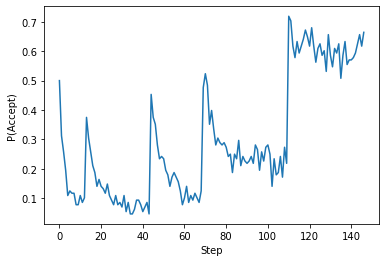

In [25]:
fig, ax = plt.subplots()

ax.plot(sampler.acceptance_fraction)

ax.set_xlabel('Step')
ax.set_ylabel('P(Accept)')

You can look at the distribution for the $D_e$ parameter to see how it changes over time.

We do that by looking at the "chain," which records the state of the sampling at each step

In [26]:
print(f'The chain is an array of shape: {sampler.chain.shape}. N Steps x N Walkers x N Parameters')

The chain is an array of shape: (147, 128, 4). N Steps x N Walkers x N Parameters


Text(0, 0.5, '$P(D_e)$')

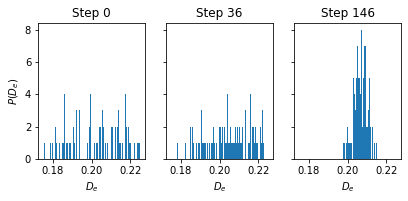

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5), sharey=True)

bins = np.linspace(0.175, 0.225, 128)
for i, ax in zip([0, burn_in_length // 4, burn_in_length - 1], axs):
    ax.hist(sampler.chain[i, :, 0], bins=bins)
    ax.set_xlabel('$D_e$')
    ax.set_title(f'Step {i}')
    
axs[0].set_ylabel('$P(D_e)$')

Note how the distribution evolves significantly over time

## Step 4: Sampling from the Posterior

Now that our sampler is ready, we can generate samples from the posterior and use that to evaluate properties of our model.

In [28]:
%%time
# Get more samples by running with the now-converged sampler
outputs = sampler.run_mcmc(64)

CPU times: user 612 ms, sys: 28.3 ms, total: 640 ms
Wall time: 36.3 s


In [29]:
samples = sampler.get_samples()  # Gets only the samples after burn-in
print(f'Retrieved {len(samples)} samples from the posterior')

Retrieved 4576 samples from the posterior


Such as the joint probability distribution between two parameters

Text(0, 0.5, '$\\alpha$')

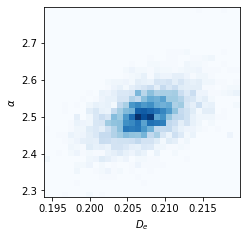

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.hist2d(samples[:, 0], samples[:, 1], bins=32, cmap='Blues');

ax.set_xlabel('$D_e$')
ax.set_ylabel('$\\alpha$')

Or confidence intervalues for certain predictions

In [31]:
# Predict the energy for each sampled parameter
r = np.linspace(0.75, 1.25, 128)
eng_predictions = [morse(r, *s[:-1]) for s in samples]

Text(0, 0.5, 'E')

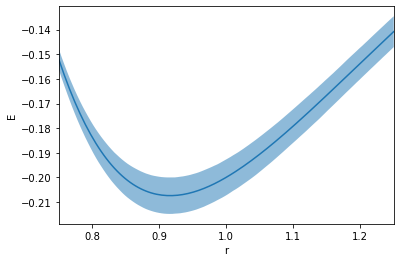

In [32]:
fig, ax = plt.subplots()

# Plot between the 2.5th and 97.5th percentiles
ax.fill_between(
    r, np.percentile(eng_predictions, 2.5, axis=0), np.percentile(eng_predictions, 97.5, axis=0),
    alpha=0.5
)

# Plot the mean
ax.plot(r, np.mean(eng_predictions, axis=0))
ax.set_xlim(0.75, 1.25)

ax.set_xlabel('r')
ax.set_ylabel('E')

## Comparing Models
Another key benefit of Bayesian modeling is we can get statistically-robust measures of which models best describe data using the so-called "marginal likelihood":

$P(D|M) = \int_\theta P(D|\theta,M)P(\theta|M)d\theta$

As discussed in the lecture, we can compute this integral by averaging the value of $P(D|\theta, M)$ over many samples of $\theta$ from our posterior distribution

In [33]:
%%time
# Using the data_loglikelihood function we defined earlier
log_evidence = [
    data_loglikelihood(x, morse, data) for x in samples
]

CPU times: user 8.48 s, sys: 36.6 ms, total: 8.52 s
Wall time: 8.47 s


These are log-likehoods, so we have to use numpy's [logaddexp](https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html) to avoid numerical problems.

In [34]:
evidence = np.logaddexp.reduce(log_evidence) - np.log(len(samples)) # Subtracting logarithms is equivalent to dividing
print(f'Log model evidence for Morse is: {evidence:.2f}')

Log model evidence for Morse is: 51.87


This number is not particularly meaningful on its own, but we can compare that of another model to see which has greater evidence

### Repeating with the Buckingham Model
We are going to go through the steps of making priors, defining likelihood functions and sampling the posterior with Kombine.

Step 1: Make the prior distributions

In [35]:
priors_buck = priors = [
    stats.norm(p, 0.1 * abs(p)) for p in buck_opt
]

# For the error distribution
rmse = np.sqrt(np.power(buckingham(data['R'], *buck_opt) - data['dE'], 2).sum())
priors_buck.append(stats.expon(scale=rmse))

Define the likelihood functions

In [36]:
lnpdf_buck = PosteriorPDF(buckingham, priors_buck, data)

Define the initial population

In [37]:
p0_buck = np.vstack([p.rvs(size=(n_walkers,)) for p in priors]).T
print(f'Created a starting array of shape: {p0_buck.shape}')

Created a starting array of shape: (128, 4)


Burn in with Kombine sampler

In [38]:
%%time
sampler_buck = kombine.Sampler(n_walkers, 4, lnpdf_buck) 
output = sampler_buck.burnin(p0_buck)

CPU times: user 1.8 s, sys: 194 ms, total: 1.99 s
Wall time: 50.5 s


Text(0, 0.5, 'P(Accept)')

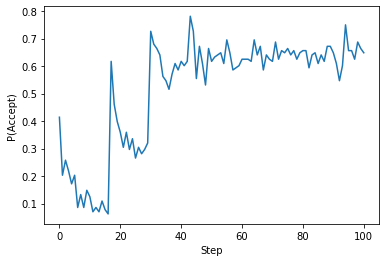

In [39]:
fig, ax = plt.subplots()

ax.plot(sampler_buck.acceptance_fraction)

ax.set_xlabel('Step')
ax.set_ylabel('P(Accept)')

Run MCMC to get more samples

In [40]:
%%time
output = sampler_buck.run_mcmc(128)

CPU times: user 1.21 s, sys: 117 ms, total: 1.33 s
Wall time: 1min 13s


Computing the evidence interval

In [41]:
%%time
samples_buck = sampler_buck.get_samples()
# Using the data_loglikelihood function we defined earlier
log_evidence_buck = [
    data_loglikelihood(x, buckingham, data) for x in samples_buck
]
evidence_buck = np.logaddexp.reduce(log_evidence_buck) - np.log(len(samples_buck)) # Subtracting logarithms is equivalent to dividing
print(f'Log model evidence for Buckingham is: {evidence_buck:.2f}')

Log model evidence for Buckingham is: 34.09
CPU times: user 13.9 s, sys: 95.8 ms, total: 14 s
Wall time: 14.1 s


Taking the difference between the evidences gives you a ["Bayes Factor."](https://en.wikipedia.org/wiki/Bayes_factor)

In [42]:
bayes_factor = np.exp(evidence - evidence_buck)
print(f'The Bayes Factor for Morse potential compared to Buckingham is {bayes_factor:.2e}')

The Bayes Factor for Morse potential compared to Buckingham is 5.28e+07


Larger values mean greater confidence and a Bayes factor of 100 is labeled as "decisive." So, as we expected earlier, the Morse model is clearly better.

Things to try: 
- Sample fewer points of data in the second cell. How does that change your Bayes factor? 
- Increase the number of walkers. How does that affect computation time?